# **FINE TUNING FASTER RCNN USING PYTORCH**

Hello Everyone!

In this Notebook I will show you how we can fine tune a Faster RCNN on the fruits images dataset. If you want to brush up about what is Faster RCNN, [here's](https://medium.com/@whatdhack/a-deeper-look-at-how-faster-rcnn-works-84081284e1cd) an awesome medium article on the same.

The code is inspired by the Pytorch docs tutorial [here](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)


## Installs and Imports

Since a lot of code for object detection is same and has to be rewritten by everyone, torchvision contributers have provided us with helper codes for training, evaluation and transformations.

Let's clone the repo and copy the libraries into working directory

In [1]:
# Download TorchVision repo to use some files from
# references/detection
#!pip install pycocotools --quiet
#!git clone https://github.com/pytorch/vision.git
#!git checkout v0.3.0

#!copy vision/references/detection/utils.py ./
#!copy vision/references/detection/transforms.py ./
#!copy vision/references/detection/coco_eval.py ./
#!copy vision/references/detection/engine.py ./
#!copy vision/references/detection/coco_utils.py ./

Lets import the libraries

In [2]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


## Dataset 

In [3]:
import os
import json

image_folder = %pwd
config_file = image_folder + "\\"+"config.json"
label_map = {}
with open(config_file, "r") as f:
    label_map = json.load(f)
label_map.sort()

Lets build the fruits images dataset!

In [4]:
# defining the files directory and testing directory
files_dir = 'E:/Projects/DoubleGameCV/DoubleGameCV/CocoTrainingData_labled'
test_dir = 'E:/Projects/DoubleGameCV/DoubleGameCV/CocoTrainingData_labled'


class DoubleImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
        
        
        # classes: 0 index is reserved for background
        self.classes = ["Background"] + label_map

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        #img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_rgb /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img_rgb.shape[1]
        ht = img_rgb.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*wt
            xmax_corr = (xmax/wt)*wt
            ymin_corr = (ymin/ht)*ht
            ymax_corr = (ymax/ht)*ht
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = int(idx)


        if self.transforms:
            
            sample = self.transforms(image = img_rgb,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_rgb = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_rgb, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = DoubleImagesDataset(files_dir, 250, 250)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[3]
print(img.shape, '\n',target)

length of dataset =  51 

(250, 250, 3) 
 {'boxes': tensor([[ 34.,  82., 105., 158.],
        [108., 159., 179., 216.],
        [165., 103., 218., 159.],
        [116.,  95., 160., 149.],
        [163.,  53., 208.,  98.],
        [ 56., 161.,  99., 196.],
        [121.,  36., 172.,  59.],
        [ 75.,  42., 129.,  96.]]), 'labels': tensor([17, 10, 48, 27, 56,  5, 35, 24]), 'area': tensor([5396., 4047., 2968., 2376., 2025., 1505., 1173., 2916.]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0]), 'image_id': 3}


Points to be noted -
1. The dataset returns a tuple. The first element is the image shape and the second element is a dictionary.
2. The image is of the size, we provided while defining the dataset and the color mode is RGB.
3. There are four bounding boxes in the image which is evident from four lists in boxes and length of labels.

And its done! 

Dataset building is one of the hardest things in the notebook. If you got till here while understand all of the above, you are doing pretty good!

Let's now see, what our data looks like. The function is inspired from [here](https://www.kaggle.com/kiwifairy/visualize-x-ray-image-with-bounding-boxes)

# Visualization

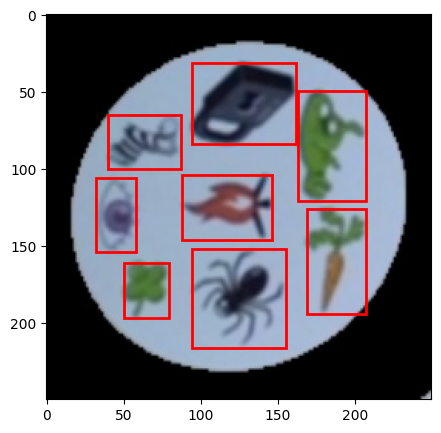

In [5]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[11]
plot_img_bbox(img, target)

You can see that we are doing great till now, as the bbox is correctly placed. 

One thing to note is that, the dataset wants us to predict only the full apple as "apple" but not the half cut one. This will be a challenge to overcome.

Lets build the model then!

# Model

We will define a function for loading the model. We will call it later

In [6]:

def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

You can clearly see, how easy it is to load and prepare the model using pytorch

# Augmentations

This is where we can apply augmentations to the image. 

The augmentations to object detection vary from normal augmentations becuase here we need to ensure that, bbox still aligns with the object correctly after transforming.

Here I have added random flip transform, feel free to customize it as you feel



In [7]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Preparing dataset

Now lets prepare datasets and dataloaders for training and testing.

In [8]:
# use our dataset and defined transformations
dataset = DoubleImagesDataset(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = DoubleImagesDataset(files_dir, 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
print(len(dataset))
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int((len(dataset))*test_split)
dataset_train = torch.utils.data.Subset(dataset, indices[:-tsize])
print(len(dataset_train))
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])
print(len(dataset_test))
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=5, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=3, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

51
41
10


# Training

Let's prepare the model for training

In [9]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(torch.cuda.is_available())
num_classes = len(label_map) + 1

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=11,
                                               gamma=0.1)

False


Let the training begin!

In [10]:
# training for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [0/9]  eta: 0:02:56  lr: 0.000629  loss: 5.2443 (5.2443)  loss_classifier: 4.0757 (4.0757)  loss_box_reg: 0.9109 (0.9109)  loss_objectness: 0.2348 (0.2348)  loss_rpn_box_reg: 0.0229 (0.0229)  time: 19.6189  data: 0.0230
Epoch: [0]  [8/9]  eta: 0:00:17  lr: 0.005000  loss: 2.8687 (3.6053)  loss_classifier: 1.8530 (2.5494)  loss_box_reg: 0.9787 (0.9487)  loss_objectness: 0.0086 (0.0914)  loss_rpn_box_reg: 0.0101 (0.0158)  time: 17.5106  data: 0.0207
Epoch: [0] Total time: 0:02:37 (17.5109 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:52  model_time: 13.0936 (13.0936)  evaluator_time: 0.0030 (0.0030)  time: 13.1046  data: 0.0080
Test:  [3/4]  eta: 0:00:11  model_time: 13.0936 (11.1865)  evaluator_time: 0.0021 (0.0023)  time: 11.1953  data: 0.0065
Test: Total time: 0:00:44 (11.1953 s / it)
Averaged stats: model_time: 13.0936 (11.1865)  evaluator_time: 0.0021 (0.0023)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) 

An AP of 0.78-0.80 is not bad but perhaps we can make it even better with more augmentations, I will leave that to you.

# Decode predictions

Our model predicts a lot of bounding boxes per image, to take out the overlapping ones, We will use **Non Max Suppression** if you want to brush up on that, check [this](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c) out.

Torchvision provides us a utility to apply nms to our predictions, lets build a function `apply_nms` using that.

In [11]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

# Testing our Model

Lets take an image from our test dataset and see, how our model does.

We will first see, how many bounding boxes does our model predict compared to actual

In [24]:
# pick one image from the test set
img, target = dataset_test[3]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  35
real #boxes:  8


Whoa! Thats a lot of bboxes. Lets plot them and check what did it predict

EXPECTED OUTPUT


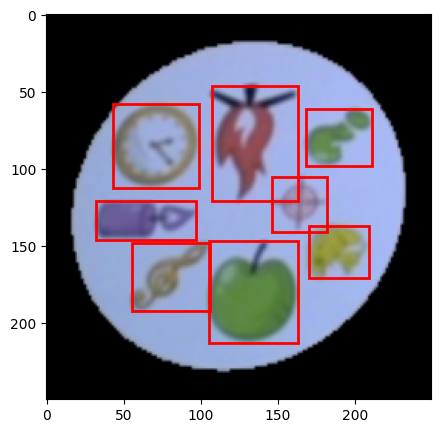

In [25]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


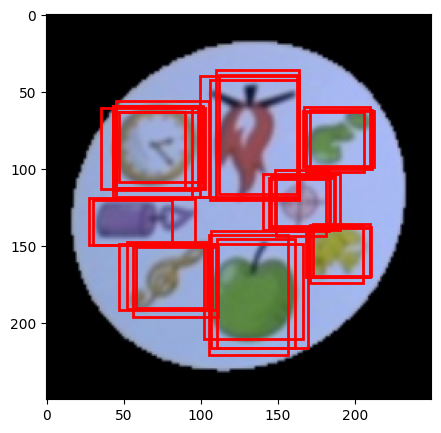

In [26]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

You can see that our model predicts a lot of bounding boxes for every apple. Lets apply nms to it and see the final output

NMS APPLIED MODEL OUTPUT


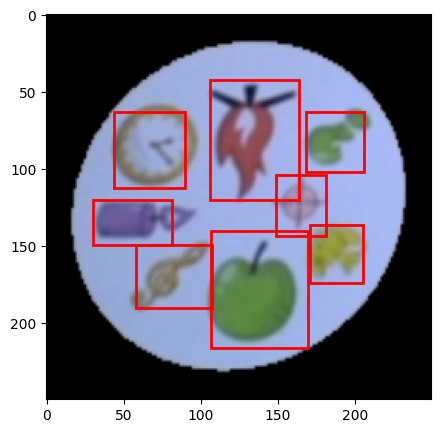

In [27]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

Now lets take an image from the test set and try to predict on it

The model does well on single object images.

You can see that our model predicts the slices too and that means a failure ☹️ . But fear not, this is just a base line model here are some ideas we can improve it - 
1. Use a better model. 
   We have the option of changing the backbone of our model which at present is `resnet 50` and the fine tune it.
   
2. We can change the training configurations like size of the images, optimizers and learning rate schedule.
3. We can add more augmentations.
   We have used the Albumentations library which has an extensive library of data augmentation functions. Feel free to explore and try them out. 

# Fin.

That's it for the notebook. 

Please tell me if you have any suggestions to improve this kernel or if you find any errors. I will be glad to hear them.

If you find the notebook useful, Consider upvoting this kernel :)